In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Dec  6 21:52:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   41C    P8    22W / 230W |     22MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import math
import time 
from mpl_toolkits.mplot3d import Axes3D

2022-12-06 21:52:05.975750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 21:52:06.075925: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 21:52:06.629637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/tmp/ENTER/envs/tf/lib/
2022-12-06 21:52:06.629704: W tensorflow/compiler/xla/stream_e

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [23]:
dt = 0.1
dx = 1
Re = 1/5     
ub = 1
sigma = 100000  # bluff body
nx = 64
ny = 64
nz = 64
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 7
Aspect ratio of Domain: 1


# Weights of CNNs layers

In [24]:
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

In [25]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*ub*dt
w2[0,1,:,:,0] = np.array(p_div_x2)*ub*dt 
w2[0,2,:,:,0] = np.array(p_div_x3)*ub*dt 

w3[0,0,:,:,0] = np.array(p_div_y1)*ub*dt
w3[0,1,:,:,0] = np.array(p_div_y2)*ub*dt
w3[0,2,:,:,0] = np.array(p_div_y3)*ub*dt 

w4[0,0,:,:,0] = np.array(p_div_z1)*ub*dt 
w4[0,1,:,:,0] = np.array(p_div_z2)*ub*dt
w4[0,2,:,:,0] = np.array(p_div_z3)*ub*dt

In [26]:
pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2 

In [27]:
pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/dt
w6[0,1,:,:,0] = np.array(pctyu2)/dt 
w6[0,2,:,:,0] = np.array(pctyu3)/dt 
w7[0,0,:,:,0] = np.array(pctyv1)/dt 
w7[0,1,:,:,0] = np.array(pctyv2)/dt 
w7[0,2,:,:,0] = np.array(pctyv3)/dt 
w8[0,0,:,:,0] = np.array(pctyw1)/dt 
w8[0,1,:,:,0] = np.array(pctyw2)/dt 
w8[0,2,:,:,0] = np.array(pctyw3)/dt 
w9[0,:,:,:,0] = 0.125

In [28]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [29]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [30]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
    ])

In [31]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    


In [32]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*2**i, 1*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [33]:
def boundary_condition_velocity(values_u,values_v,values_w,nx):
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(values_u)[0,1,:,:,0])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,nx-1,:,:,0].assign(tf.Variable(values_u)[0,nx-2,:,:,0])      
    tempv[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempw[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):    
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nx-1,:,:,0].assign(tf.Variable(values_p)[0,nx-2,:,:,0])  
    return tempp

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb  
    return tf.convert_to_tensor(b)

def bluff_body(values_u,values_v,values_w,sigma,dt,xmin,xmax,ymin,ymax,zmin,zmax):
    temp1 = tf.Variable(values_u)
    temp2 = tf.Variable(values_v)
    temp3 = tf.Variable(values_w)
    temp1[0,zmin:zmax,ymin:ymax,xmin:xmax,0].assign(temp1[0,zmin:zmax,ymin:ymax,xmin:xmax,0]/(1+dt*sigma))
    temp2[0,zmin:zmax,ymin:ymax,xmin:xmax,0].assign(temp2[0,zmin:zmax,ymin:ymax,xmin:xmax,0]/(1+dt*sigma))
    temp3[0,zmin:zmax,ymin:ymax,xmin:xmax,0].assign(temp3[0,zmin:zmax,ymin:ymax,xmin:xmax,0]/(1+dt*sigma))
    return temp1,temp2,temp3

def save_data(values_u,values_v,values_w,values_p,n_out,itime):
    if itime % n_out == 0:  
        np.save("result_3d_27point/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("result_3d_27point/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("result_3d_27point/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("result_3d_27point/p"+str(itime), arr=values_p[0,:,:,:,0])

# Initialise

In [42]:
input_shape = (1,nx,ny,nz,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)

multi_itr = 10       # Iterations of multi-grid 
j_itr = 1             # Iterations of Jacobi 
ntime = 1001      # Time steps
n_out = 500           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0 
mgsolver = True
save_fig = False
Restart = False
ctime = 0         
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)

Mesh resolution: (1, 64, 64, 64, 1)
Time step: 1001
Initial time: 0


In [43]:
if Restart == True:
    temp1 = np.load('result_3d_27point/u2500.npy').astype('float32')
    temp2 = np.load('result_3d_27point/v2500.npy').astype('float32')
    temp3 = np.load('result_3d_27point/w2500.npy').astype('float32')
    temp4 = np.load('result_3d_27point/p2500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 2500
    ctime_old = nrestart*dt

In [44]:
start = time.time()
for itime in range(ntime): 
    ctime = ctime + dt
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
    values_p = boundary_condition_pressure(values_p,nx)
# Momentum equation              
    a_u = CNN3D_central_2nd_dif(values_u) - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u
    a_v = CNN3D_central_2nd_dif(values_v) - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v
    a_w = CNN3D_central_2nd_dif(values_w) - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w)
    b_w = 0.5*a_w + values_w
    
    c_u = CNN3D_central_2nd_dif(b_u) - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    
    c_v = CNN3D_central_2nd_dif(b_v) - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v)

    c_w = CNN3D_central_2nd_dif(b_w) - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w)
    
    values_u = values_u + c_u    
    values_v = values_v + c_v
    values_w = values_w + c_w
# IBM 
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma,dt,11,21,27,37,27,37)
# gradp            
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
# possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = np.zeros([1,1,1,1,1])
            r = CNN3D_A_64(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
            r_32 = CNN3D_res_64(r) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r_1 = CNN3D_res_2(r_2)   
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/w5[0,1,1,1,0] + r_1/w5[0,1,1,1,0])
            w_2 = CNN3D_prol_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])
            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])
            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])
            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])
            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])
            w_64 = CNN3D_prol_32(w_32) 
            values_p = values_p - w_64
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])         
            values_p = (values_p - CNN3D_A_64(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)       
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)    
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma,dt,11,21,27,37,27,37)
    print('Time step:', itime) 
    if save_fig == True:
        save_data(values_u,values_v,values_w,values_p,n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
Time step: 20
Time step: 21
Time step: 22
Time step: 23
Time step: 24
Time step: 25
Time step: 26
Time step: 27
Time step: 28
Time step: 29
Time step: 30
Time step: 31
Time step: 32
Time step: 33
Time step: 34
Time step: 35
Time step: 36
Time step: 37
Time step: 38
Time step: 39
Time step: 40
Time step: 41
Time step: 42
Time step: 43
Time step: 44
Time step: 45
Time step: 46
Time step: 47
Time step: 48
Time step: 49
Time step: 50
Time step: 51
Time step: 52
Time step: 53
Time step: 54
Time step: 55
Time step: 56
Time step: 57
Time step: 58
Time step: 59
Time step: 60
Time step: 61
Time step: 62
Time step: 63
Time step: 64
Time step: 65
Time step: 66
Time step: 67
Time step: 68
Time step: 69
Time step: 70
Time step: 71
Ti

Time step: 554
Time step: 555
Time step: 556
Time step: 557
Time step: 558
Time step: 559
Time step: 560
Time step: 561
Time step: 562
Time step: 563
Time step: 564
Time step: 565
Time step: 566
Time step: 567
Time step: 568
Time step: 569
Time step: 570
Time step: 571
Time step: 572
Time step: 573
Time step: 574
Time step: 575
Time step: 576
Time step: 577
Time step: 578
Time step: 579
Time step: 580
Time step: 581
Time step: 582
Time step: 583
Time step: 584
Time step: 585
Time step: 586
Time step: 587
Time step: 588
Time step: 589
Time step: 590
Time step: 591
Time step: 592
Time step: 593
Time step: 594
Time step: 595
Time step: 596
Time step: 597
Time step: 598
Time step: 599
Time step: 600
Time step: 601
Time step: 602
Time step: 603
Time step: 604
Time step: 605
Time step: 606
Time step: 607
Time step: 608
Time step: 609
Time step: 610
Time step: 611
Time step: 612
Time step: 613
Time step: 614
Time step: 615
Time step: 616
Time step: 617
Time step: 618
Time step: 619
Time step:

Text(0.5, 1.0, 'central xy plane')

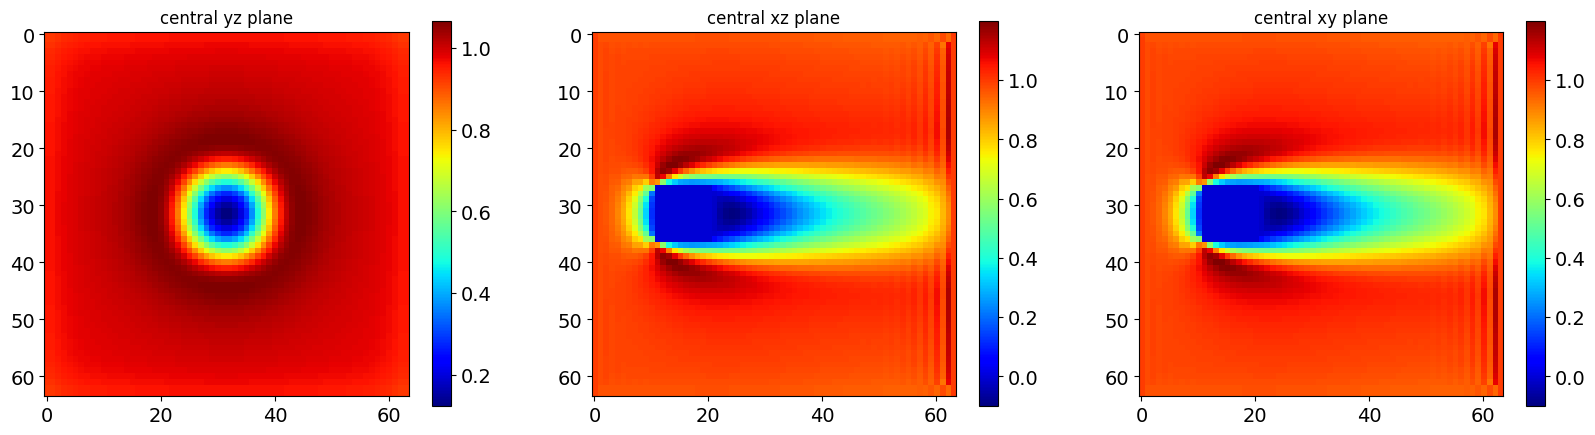

In [45]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values_u[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane')
plt.subplot(1,3,2)
plt.imshow(values_u[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane')
plt.subplot(1,3,3)
plt.imshow(values_u[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane')

Text(0.5, 1.0, 'central xy plane')

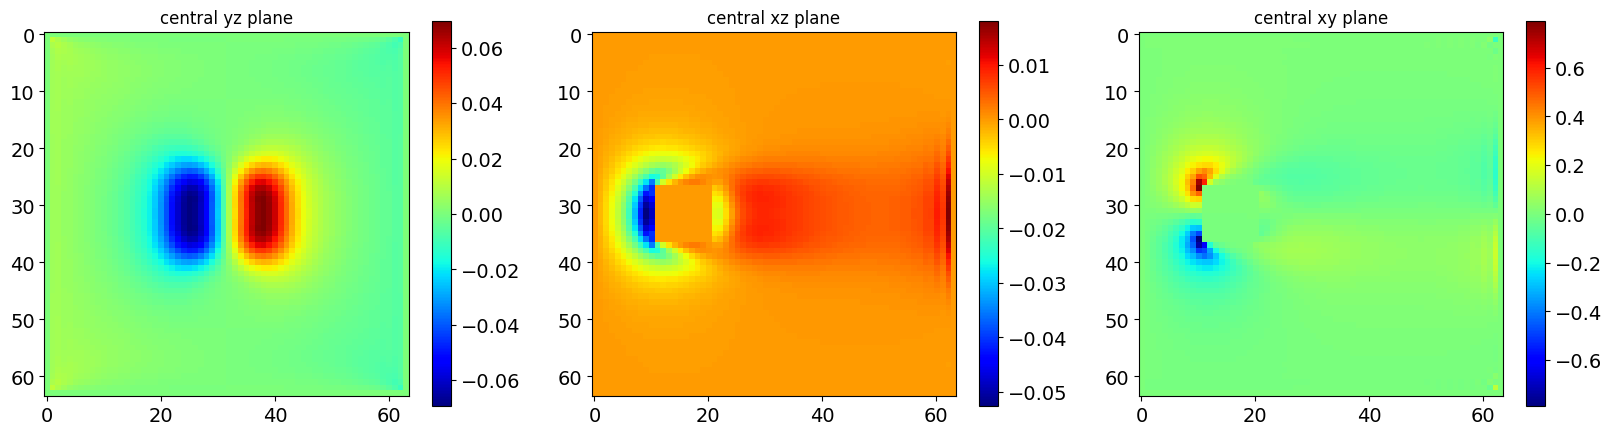

In [46]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values_v[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',)
plt.subplot(1,3,2)
plt.imshow(values_v[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane')
plt.subplot(1,3,3)
plt.imshow(values_v[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane')

Text(0.5, 1.0, 'central xy plane')

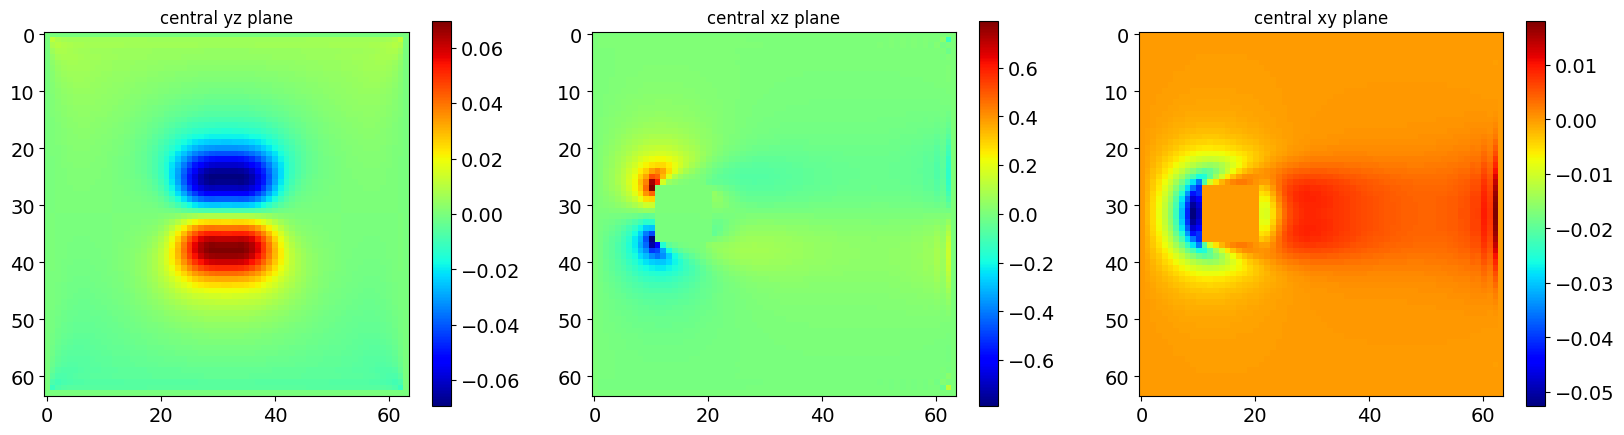

In [47]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values_w[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane')
plt.subplot(1,3,2)
plt.imshow(values_w[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane')
plt.subplot(1,3,3)
plt.imshow(values_w[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane')

Text(0.5, 1.0, 'central xy plane')

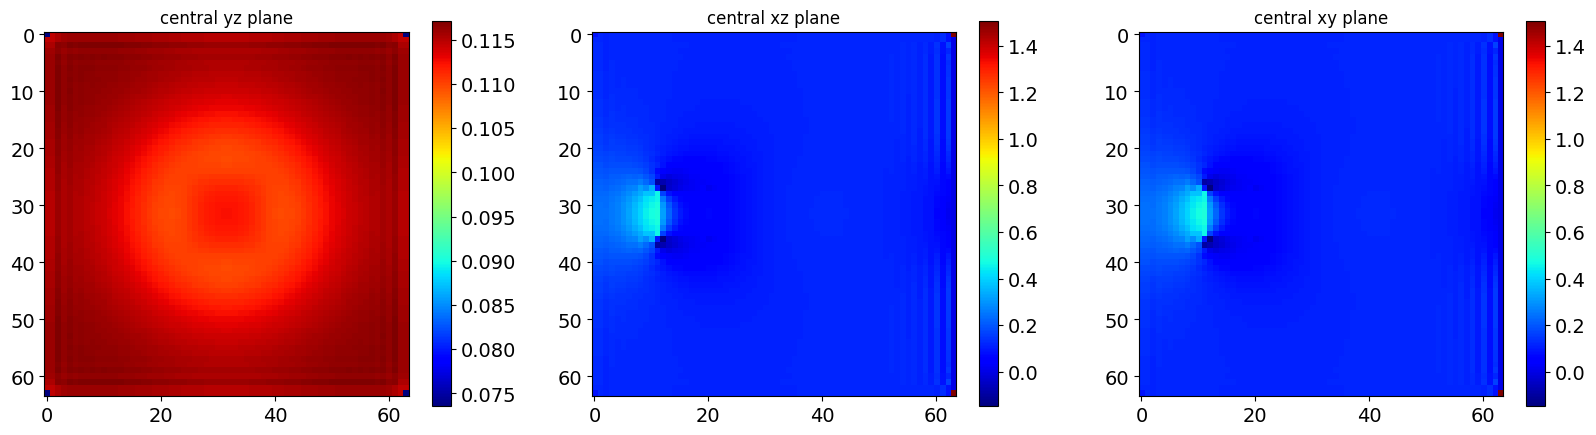

In [48]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values_p[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane')
plt.subplot(1,3,2)
plt.imshow(values_p[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane')
plt.subplot(1,3,3)
plt.imshow(values_p[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane')